# TASK 2.2: Tracking with a Kalman Filter

In [10]:
from __future__ import print_function
from skimage import io
from sort import Sort
from IPython import display as dp
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pickle as pkl
import os
import time
import cv2
%matplotlib inline

First we load all the data

In [11]:
# Detection to DataFrame
def get_detection_dataframe(detections):
    bboxes = []
    bsizes = []
    bdetections = []
    tracks = list(range(0, len(detections)))
    
    colours = []
    for i in range(len(detections)):
        colours.append(tuple(np.random.choice(range(256), size=3).astype('int')))
    
    for detection in detections:
        bbox = np.array(detection.getBBox()).astype('int')
        bboxes.append(bbox)

        bsize = int(detection.areaOfRec())
        bsizes.append(bsize)

        bdetections.append(detection)

    detec = {
        'track': tracks,
        'detection': bdetections,
        'bbox': bboxes,
        'size': bsizes,
        'colour': colours,
    }
    detections_pd = pd.DataFrame(detec)
    detections_pd = detections_pd.sort_values(by=['size'], ascending=False)
    detections_pd = detections_pd.reset_index(drop=True)
    
    return detections_pd

In [18]:
# Load paths
file_path = 'detection_pkls/retinanet_101_detections.pkl'
data_path = '../datasets/AICity_data/train/S03/c010/'
video_path = '../datasets/AICity_data/train/S03/c010/vdo.avi'

# Load detections
with open(file_path , 'rb') as f:
    all_detections = pkl.load(f)


get_detection_dataframe(all_detections[str(0)]).sort_values("track")

,track,detection,bbox,size,colour
0,0,"Frame 0, TL [1284.8372802734375,362.1326904296...","[1284, 362, 1520, 539]",41907,"(8, 77, 5)"
2,1,"Frame 0, TL [564.6638793945312,96.273307800292...","[564, 96, 658, 168]",6779,"(25, 204, 174)"
4,2,"Frame 0, TL [928.7540283203125,78.073799133300...","[928, 78, 1014, 145]",5791,"(140, 209, 225)"
11,3,"Frame 0, TL [885.072265625,94.19532012939453],...","[885, 94, 935, 141]",2404,"(48, 215, 98)"
13,4,"Frame 0, TL [908.677734375,92.77952575683594],...","[908, 92, 944, 141]",1736,"(72, 35, 161)"
9,5,"Frame 0, TL [579.739501953125,74.2380752563476...","[579, 74, 658, 110]",2870,"(243, 234, 96)"
1,6,"Frame 0, TL [542.8624877929688,68.340904235839...","[542, 68, 631, 159]",8089,"(176, 64, 205)"
14,7,"Frame 0, TL [874.1964721679688,99.487159729003...","[874, 99, 910, 142]",1533,"(39, 17, 2)"
6,8,"Frame 0, TL [895.2154541015625,88.084892272949...","[895, 88, 961, 141]",3582,"(233, 255, 208)"
7,9,"Frame 0, TL [1178.972412109375,103.75167846679...","[1178, 103, 1228, 164]",3049,"(196, 142, 100)"


Starting Tracking

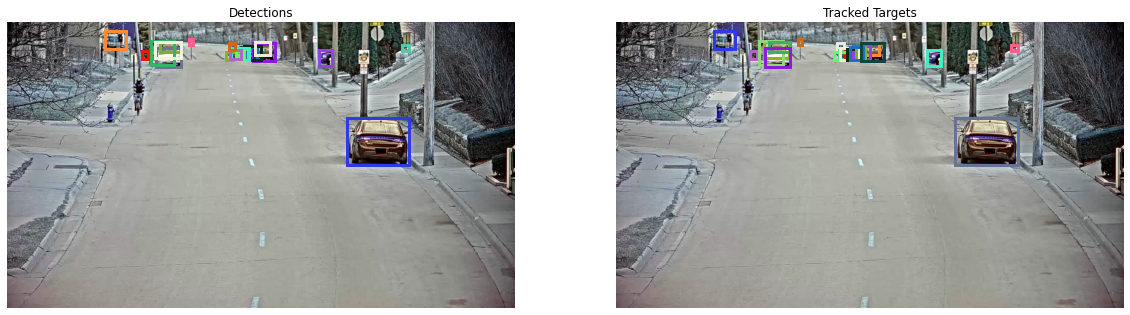

[[1285  362 1520  540]
 [ 564   96  659  168]
 [ 929   77 1014  145]
 [ 903   93  941  140]
 [ 888   94  929  141]
 [ 578   73  658  112]
 [ 874   96  916  141]
 [ 543   68  637  159]
 [1178  103 1228  170]
 [ 896   87  964  142]
 [ 847  107  905  142]
 [ 866  105  895  140]
 [ 569   79  649  129]
 [ 688   63  704   84]
 [ 837   79  861  102]
 [ 912   87  952  130]
 [1493   86 1520  108]
 [ 935   73  995  124]
 [ 508  108  534  138]
 [ 370   31  451  100]
 [ 848   90  944  143]]


TypeError: tuple indices must be integers or slices, not tuple

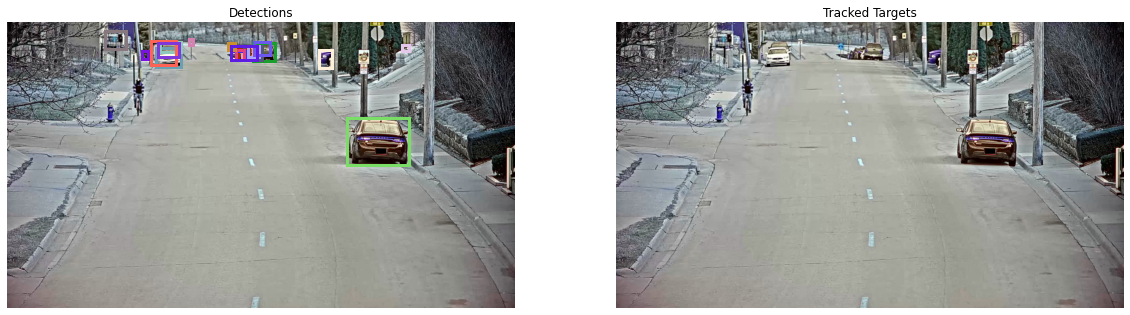

In [24]:
# Load video frames
vidcap = cv2.VideoCapture(video_path)
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

# Algorithm Params
display = True
total_time = 0.0
out = []

# Set Iterative Plot
if display:
    plt.ion() 
    fig, ax = plt.subplots(1, 2,figsize=(20,20))

# Kalman Sort Tracker
mot_tracker = Sort()

# Iterate Frames
for frame in range(num_frames):
    dets = []
    colors = []
    if display:
        _, im = vidcap.read() # Read frame
        detections = get_detection_dataframe(all_detections[str(frame)]).sort_values("track") # Load detections

        for (track_id, det, bbox, size, colour) in detections.itertuples(index=False): # Iter All Detections
            colour = [c/255 for c in colour] # Normalize colour values
            coords = (bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1] # Format (lower_x, lower_y), width, height
            ax[0].add_patch(plt.Rectangle(*coords,fill=False,edgecolor=colour,lw=3)) # Draw bbox
            dets.append(bbox)
            colors.append(colour)

        ax[0].imshow(im)
        ax[0].axis('off')
        ax[0].set_title('Detections')

    if display:
        ax[1].imshow(im)
        ax[1].axis('off')
        ax[1].set_title('Tracked Targets')
    
    # Update sort tracer
    start_time = time.time()
    print(np.array(dets))
    trackers = mot_tracker.update(np.array(dets))
    cycle_time = time.time() - start_time
    total_time += cycle_time
    # Save tracker
    out.append(trackers)

    for d in trackers:
        if display:
            d = d.astype(np.uint32)
            ax[1].add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colors[d[4] % len(colors)]))
            ax[1].set_adjustable('box')
    

    # Clear Display
    if display:
        dp.clear_output(wait=True)
        dp.display(plt.gcf())
        time.sleep(0.000001)
        ax[0].cla()
        ax[1].cla()